In [1]:
import sys
 
import tensorflow.keras
import tensorflow as tf
import numpy as np
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.12.1
Keras Version: 2.12.0

Python 3.9.17 (main, Jul  5 2023, 20:41:20) 
[GCC 11.2.0]
GPU is available


In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)
    


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pdb
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, BatchNormalization, Dropout, Input, MaxPool2D , Flatten
import cv2
import imgaug.augmenters as iaa
from PIL import Image, ImageDraw
from PIL import ImagePath
from tensorflow.keras.models import Model, load_model
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import LearningRateScheduler
import random
from tqdm import tqdm
from sklearn.metrics import roc_curve,precision_recall_curve, auc , multilabel_confusion_matrix
import seaborn as sns
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0 , EfficientNetB4 , EfficientNetB7
import tensorflow as tf
from tensorflow.keras.utils import to_categorical ,Sequence
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from numpy import save ,load

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [4]:
train_images_path = 'Severstaldataset-20230720T140741Z-001/Severstaldataset/train_images'
#train_masks_path = 'Severstaldataset-20230720T140741Z-001/Severstaldataset/train_masks'
train_image_names = os.listdir(train_images_path)
train_masks_npy_path = 'Severstaldataset-20230720T140741Z-001/Severstaldataset/train_masks_npy'
train_df = pd.read_csv('Severstaldataset-20230720T140741Z-001/Severstaldataset/train.csv')

In [5]:
train_image_names = pd.DataFrame(train_image_names,
                                              columns =['ImageId'])
train_df = pd.merge(train_df,train_image_names,how = 'outer',on = ['ImageId','ImageId'])
train_df = train_df.fillna(' ')
train_df.head(5)

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1.0,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3.0,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1.0,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4.0,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3.0,229501 11 229741 33 229981 55 230221 77 230468...


In [6]:
train_data = pd.pivot_table(train_df, values='EncodedPixels', index='ImageId',columns='ClassId', aggfunc=np.sum,fill_value= ' ').astype(str)
del train_data[' ']
train_data = train_data.reset_index()
train_data.columns = ['ImageId','Defect_1','Defect_2','Defect_3','Defect_4']
train_data.head()

,ImageId,Defect_1,Defect_2,Defect_3,Defect_4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,
1,00031f466.jpg,,,,
2,000418bfc.jpg,,,,
3,000789191.jpg,,,,
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,


In [7]:
# 'hasDefect' column indicates if there is atleast one defect in the image
insert_column = []
for i in range(len(train_data)):
    if (train_data['Defect_1'][i]== ' ' and train_data['Defect_2'][i]== ' ' and train_data['Defect_3'][i]==' ' and train_data['Defect_4'][i]==' '):
        insert_column.append(0)
    else:
        insert_column.append(1)
train_data['hasDefect'] = insert_column

# 'hasDefect_1' column indicates if there is type 1 defect in the image
insert_column = []
for i in range(len(train_data)):
    if train_data['Defect_1'][i]==' ':
        insert_column.append(0)
    else:
        insert_column.append(1)
train_data['hasDefect_1'] = insert_column

# 'hasDefect_2' column indicates if there is type 2 defect in the image
insert_column = []
for i in range(len(train_data)):
    if train_data['Defect_2'][i]==' ':
        insert_column.append(0)
    else:
        insert_column.append(1)
train_data['hasDefect_2'] = insert_column

# 'hasDefect_3' column indicates if there is type 3 defect in the image
insert_column = []
for i in range(len(train_data)):
    if train_data['Defect_3'][i]==' ':
        insert_column.append(0)
    else:
        insert_column.append(1)
train_data['hasDefect_3'] = insert_column

# 'hasDefect_4' column indicates if there is type 4 defect in the image
insert_column = []
for i in range(len(train_data)):
    if train_data['Defect_4'][i]==' ':
        insert_column.append(0)
    else:
        insert_column.append(1)
train_data['hasDefect_4'] = insert_column

train_data.head()

,ImageId,Defect_1,Defect_2,Defect_3,Defect_4,hasDefect,hasDefect_1,hasDefect_2,hasDefect_3,hasDefect_4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,,1,1,0,0,0
1,00031f466.jpg,,,,,0,0,0,0,0
2,000418bfc.jpg,,,,,0,0,0,0,0
3,000789191.jpg,,,,,0,0,0,0,0
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,,1,0,0,1,0


In [8]:
# Images with defect 1 , 2 , 3 , 4
print('There are {} images with defect 1'.format(sum(train_data['hasDefect_1'])))
print('There are {} images with defect 2'.format(sum(train_data['hasDefect_2'])))
print('There are {} images with defect 3'.format(sum(train_data['hasDefect_3'])))
print('There are {} images with defect 4'.format(sum(train_data['hasDefect_4'])))

There are 897 images with defect 1
There are 247 images with defect 2
There are 5150 images with defect 3
There are 801 images with defect 4


In [9]:
insert_column = []
for i in range(len(train_data)):
    if train_data['hasDefect_2'].iloc[i]==1:
        insert_column.append(2)
    elif train_data['hasDefect_4'].iloc[i]==1:
        insert_column.append(4)
    elif train_data['hasDefect_1'].iloc[i]==1:
        insert_column.append(1)
    elif train_data['hasDefect_3'].iloc[i]==1:
        insert_column.append(3)
    else:
        insert_column.append(0)
train_data['minority_preference']= insert_column
train_data.head()

,ImageId,Defect_1,Defect_2,Defect_3,Defect_4,hasDefect,hasDefect_1,hasDefect_2,hasDefect_3,hasDefect_4,minority_preference
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,,1,1,0,0,0,1
1,00031f466.jpg,,,,,0,0,0,0,0,0
2,000418bfc.jpg,,,,,0,0,0,0,0,0
3,000789191.jpg,,,,,0,0,0,0,0,0
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,,1,0,0,1,0,3


In [10]:
#Train Test validation split
X = train_data.copy()
X_train, X_test = train_test_split(X, test_size = 0.2, stratify = X['minority_preference'],random_state=15)
print(X_train.shape, X_test.shape)

(10054, 11) (2514, 11)


distribution image with defect and non defect

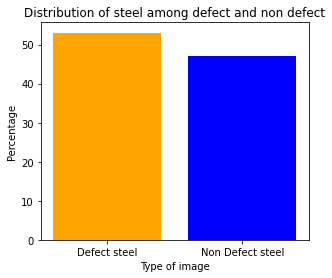

There are 10054 Total images
There are 5333 with atleast 1 defect images
There are 4721 0 defect images
53.04% of defect steel images and 46.96% of Non defect images


In [11]:
#Images with defect and non defect steel
n_total_images = X_train.shape[0]
n_defect_images = sum(X_train.hasDefect)
n_nodefect_images = n_total_images -  n_defect_images

plt.figure(figsize = (4.8, 4))
plt.xlabel('Type of image')
plt.ylabel('Percentage')
plt.bar(['Defect steel', 'Non Defect steel'], [round(((n_defect_images/ n_total_images)* 100 ),2), round(((n_nodefect_images/ n_total_images)* 100 ),2)],
        color = ['orange','blue'] , width = 0.8)
plt.title('Distribution of steel among defect and non defect')
plt.show()

print('There are {} Total images'.format(n_total_images))
print('There are {} with atleast 1 defect images'.format(n_defect_images))
print('There are {} 0 defect images'.format(n_nodefect_images))
print('{}% of defect steel images and {}% of Non defect images'.format(round(((n_defect_images/ n_total_images)* 100 ),2),round(((n_nodefect_images/ n_total_images)* 100 ),2)))

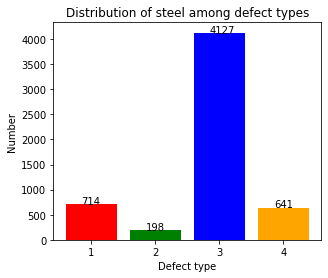

In [12]:
plt.figure(figsize = (4.8, 4))
plt.xlabel('Defect type')
plt.ylabel('Number')
plt.bar([1,2,3,4],X_train[['hasDefect_1','hasDefect_2','hasDefect_3','hasDefect_4']].sum(axis = 0),
        color = ['red','green','blue','orange'] , width = 0.8)
xlocs, xlabs = plt.xticks()
plt.title('Distribution of steel among defect types')
for i, v in zip([1,2,3,4],X_train[['hasDefect_1','hasDefect_2','hasDefect_3','hasDefect_4']].sum(axis = 0)):
    plt.text(xlocs[i] - 0.15, v + 0.5, str(v))
plt.show()

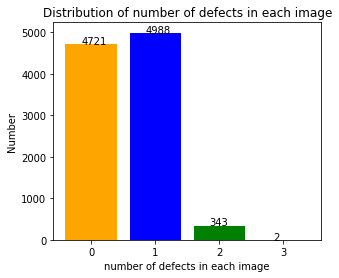

In [13]:
plt.figure(figsize = (4.8, 4))
plt.xlabel('number of defects in each image')
plt.ylabel('Number')
plt.bar([str(0),str(1),str(2),str(3)], X_train[['hasDefect_1','hasDefect_2','hasDefect_3','hasDefect_4']].sum(axis = 1).value_counts().sort_index(),
        color = ['orange','blue','green','red'] , width = 0.8)
plt.title('Distribution of number of defects in each image')

xlocs, xlabs = plt.xticks()
for i, v in zip( [0,1,2,3], X_train[['hasDefect_1','hasDefect_2','hasDefect_3','hasDefect_4']].sum(axis = 1).value_counts().sort_index()):
    plt.text(xlocs[i] - 0.15, v + 0.5, str(v))
plt.show()

RLE ENCODING

Sample images with no defects:


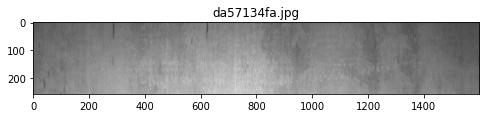

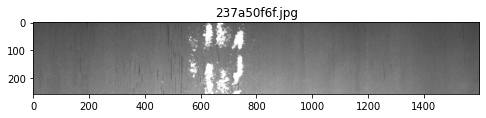

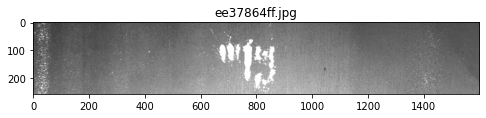

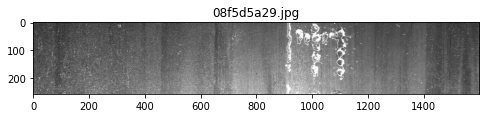

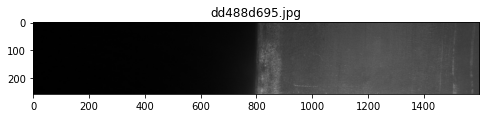

In [14]:
# 5 images having no defects
tmp = []
cnt=0
print("Sample images with no defects:")
for i in X_train['ImageId'][X_train['hasDefect']==0]:
    if cnt<5:
        fig, ax = plt.subplots(1,1,figsize=(8, 7))
        # img = Image.open(os.path.join(train_images_path,i))
        img = cv2.imread(os.path.join(train_images_path , i))
        plt.imshow(img)
        ax.set_title(i)
        plt.show()
        cnt+=1

In [15]:
# image_width = []
# image_height = []

# for ele in tqdm(X_train.ImageId) :
#   img = Image.open(os.path.join(train_images_path,ele))
#   image_width.append(img.width)
#   image_height.append(img.height)
# image_width = np.array(image_width)
# image_height = np.array(image_height)

In [16]:
 #print(( image_width != 1600 ).sum())
 #print(( image_height != 256 ).sum())

RGB

In [15]:
colourmap = [[0, 0, 0], [255, 105, 180], [ 180,255,105],[ 105, 180,255], [255, 255,105]]
classes_tocolour =   dict({0: [0, 0, 0], 1: [255, 105, 180], 2:  [180,255,105], 3:[105, 180,255], 4: [ 255, 255,105]})
classes = [0,1,2,3,4]

Convert encoded pixels into mask using function from https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

In [16]:
def rle2_1frame(mask_rle_list, shape=(1600,256)):
    '''
    mask_rle: list of strings(run-length as string formated (start length)), each for 1,2,3,4 defects
    shape: (width,height) of array to return
    Returns 2 D numpy array. 0 for no defect, 1 defect 1 , 2 for defect 2 , 3 for defect 3 and 4 for defect 4
    This function is specific to this competition
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for i in range(len(mask_rle_list)):
      if mask_rle_list[i] != ' ' :
        sp = mask_rle_list[i].split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (sp[0:][::2], sp[1:][::2])]
        starts -= 1
        ends = starts + lengths
        # pdb.set_trace()
        for lo, hi in zip(starts, ends):
            img[lo:hi] = i+1
    img = img.reshape(shape).T
    return img #256 * 1600

In [17]:
def rle_to_RGBmask(mask_rle_list, classes_tocolour ,shape=(1600,256)):
  '''
  This function will save the RGB masks from RLE
  '''
  img = rle2_1frame(mask_rle_list, shape=(1600,256))
  # pdb.set_trace()
  #Till here we got 256 X 1600 and now we have to convert this matrix to an RGB encoded mask
  RGB_image = []
  for outer in img :
    col = []
    for inner in outer :
      col.append(classes_tocolour.get(inner))
    RGB_image.append(col)
  return np.array(RGB_image) #256 X 1600 X 3

In [18]:
def RGBmask_to_width_height_classes ( rgb_mask , colourmap ):
  '''
  This function will convert the RGB mask to width X height X classes
  '''
  output_mask = []
  for i , color in enumerate(colourmap):
    cmap = np.all(np.equal(rgb_mask , color ), axis = -1)
    cmap.astype(int)
    output_mask.append(cmap)
  output_mask = np.stack(output_mask , axis = -1)
  output_mask = output_mask.astype(np.uint8)
  return output_mask #output will have five channels. any pixel will have 1 in any one of the 5 channels

In [19]:
def width_height_classes_toRGB(img,classes_tocolour):
  ''' Given an widthXheightXclasses we need to convert into an RGB image 256X1600X5  to 256 X 1600 X 3'''
  img = np.argmax(img,axis= -1) #256 X 1600
  RGB_image = []
  for outer in img :
    col = []
    for inner in outer :
      col.append(classes_tocolour.get(inner))
    RGB_image.append(col)
  return np.array(RGB_image) #256 X 1600 X 3

In [20]:
def one_frame_rgb(img,classes_tocolour):
  RGB_image = []
  for outer in img :
    col = []
    for inner in outer :
      col.append(classes_tocolour.get(inner))
    RGB_image.append(col)
  return np.array(RGB_image) #256 X 1600 X 3

In [23]:
 # saving the widthXheightXchannels for all the train images
# train_numpy_masks = []
# for index, row in X_train.iterrows():
#   mask_rle_list = [row.Defect_1,row.Defect_2,row.Defect_3,row.Defect_4]
#   rgb_mask = rle_to_RGBmask(mask_rle_list, classes_tocolour, shape=(1600, 256))
#   image_mask = RGBmask_to_width_height_classes(rgb_mask, colourmap)  #256 X 1600 X 5
#   mask_name = row.ImageId.split('.')[0]
#   mask_name = mask_name + '.npy'
#   mask_name = os.path.join(train_masks_npy_path,mask_name)
#   train_numpy_masks.append(mask_name)
#   # save to npy file
#   save(mask_name,image_mask)
#
# test_numpy_masks = []
# for index, row in X_test.iterrows():
#   mask_rle_list = [row.Defect_1,row.Defect_2,row.Defect_3,row.Defect_4]
#   rgb_mask = rle_to_RGBmask(mask_rle_list, classes_tocolour, shape=(1600, 256))
#   image_mask = RGBmask_to_width_height_classes(rgb_mask, colourmap)  #256 X 1600 X 5
#   mask_name = row.ImageId.split('.')[0]
#   mask_name = mask_name + '.npy'
#   mask_name = os.path.join(train_masks_npy_path,mask_name)
#   test_numpy_masks.append(mask_name)
   # save to npy file
#   save(mask_name,image_mask)
# save('Severstaldataset-20230720T140741Z-001/Severstaldataset/train_numpy_masks.npy',np.array(train_numpy_masks))
# save('Severstaldataset-20230720T140741Z-001/Severstaldataset/test_numpy_masks.npy',np.array(test_numpy_masks))
# X_train['train_numpy_masks'] = train_numpy_masks
# X_test['test_numpy_masks'] = test_numpy_masks

In [21]:
X_train['numpy_masks'] = load('Severstaldataset-20230720T140741Z-001/Severstaldataset/train_numpy_masks.npy')
X_test['numpy_masks'] = load('Severstaldataset-20230720T140741Z-001/Severstaldataset/test_numpy_masks.npy')

Images and masks with out any defects
--------------------------------------------------------------------------------


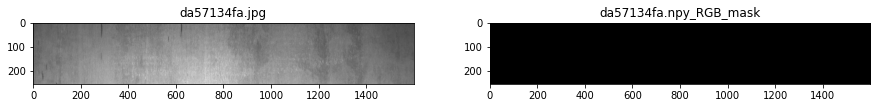

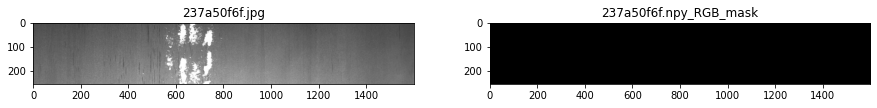

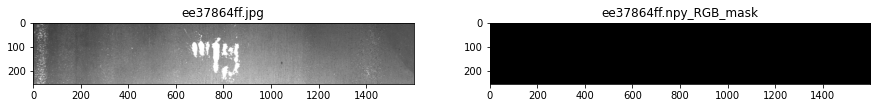

In [22]:
# Visualization: Sample images having defect
print('Images and masks with out any defects')
cnt = 0
for i in X_train['ImageId'][X_train.hasDefect == 0 ].values :
  if cnt < 3:
    fig, (ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize=(15, 10))
    img = cv2.imread(os.path.join(train_images_path , i))
    ax1.imshow(img)
    ax1.set_title(i)

    file_name = (i).split('.')[0] + '.npy'
    original_mask = np.load(os.path.join(train_masks_npy_path, file_name)) #256 X 1600X5
    original_mask = width_height_classes_toRGB(original_mask, classes_tocolour)
    # img = cv2.imread(os.path.join(train_images_path , i))
    ax2.imshow(original_mask)
    ax2.set_title(file_name + '_RGB_mask')
    # plt.show()
    cnt+=1
  else :
    break
print('-'*80)

Images and masks with type1 defects
--------------------------------------------------------------------------------


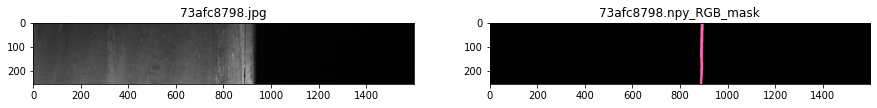

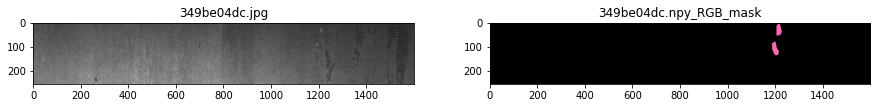

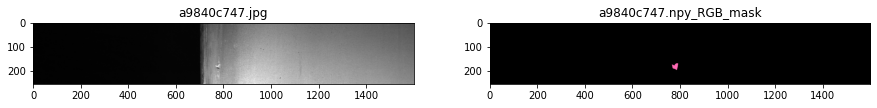

In [23]:
# Visualization: Sample images having defect
print('Images and masks with type1 defects')
cnt = 0
for i in X_train['ImageId'][(X_train.hasDefect_1 == 1) & (X_train.hasDefect_2 == 0) & (X_train.hasDefect_3 == 0) & (X_train.hasDefect_4 == 0)].values :
  if cnt < 3:
    fig, (ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize=(15, 10))
    img = cv2.imread(os.path.join(train_images_path , i))
    ax1.imshow(img)
    ax1.set_title(i)

    file_name = (i).split('.')[0] + '.npy'
    original_mask = np.load(os.path.join(train_masks_npy_path, file_name)) #256 X 1600X5
    original_mask = width_height_classes_toRGB(original_mask, classes_tocolour)
    # img = cv2.imread(os.path.join(train_images_path , i))
    ax2.imshow(original_mask)
    ax2.set_title(file_name + '_RGB_mask')
    # plt.show()
    cnt+=1
  else :
    break
print('-'*80)

Images and masks with type2 defects
--------------------------------------------------------------------------------


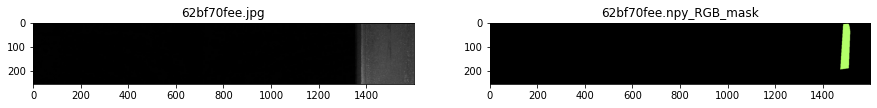

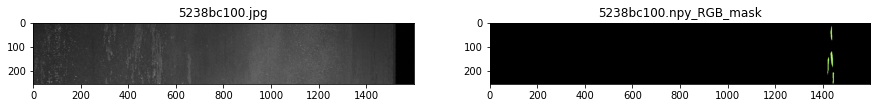

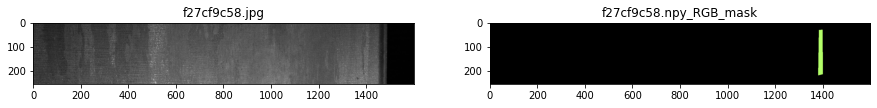

In [24]:
# Visualization: Sample images having defect
print('Images and masks with type2 defects')
cnt = 0
for i in X_train['ImageId'][(X_train.hasDefect_1 == 0) & (X_train.hasDefect_2 == 1) & (X_train.hasDefect_3 == 0) & (X_train.hasDefect_4 == 0)].values :
  if cnt < 3:
    fig, (ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize=(15, 10))
    img = cv2.imread(os.path.join(train_images_path , i))
    ax1.imshow(img)
    ax1.set_title(i)

    file_name = (i).split('.')[0] + '.npy'
    original_mask = np.load(os.path.join(train_masks_npy_path, file_name)) #256 X 1600X5
    original_mask = width_height_classes_toRGB(original_mask, classes_tocolour)
    # img = cv2.imread(os.path.join(train_images_path , i))
    ax2.imshow(original_mask)
    ax2.set_title(file_name + '_RGB_mask')
    # plt.show()
    cnt+=1
  else :
    break
print('-'*80)

Images and masks with type3 defects
--------------------------------------------------------------------------------


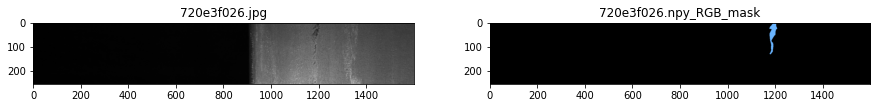

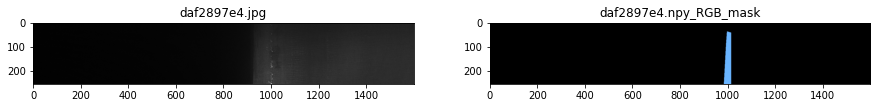

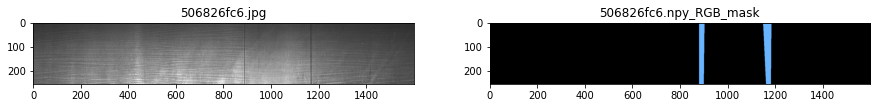

In [25]:
# Visualization: Sample images having defect
print('Images and masks with type3 defects')
cnt = 0
for i in X_train['ImageId'][(X_train.hasDefect_1 == 0) & (X_train.hasDefect_2 == 0) & (X_train.hasDefect_3 == 1) & (X_train.hasDefect_4 == 0)].values :
  if cnt < 3:
    fig, (ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize=(15, 10))
    img = cv2.imread(os.path.join(train_images_path , i))
    ax1.imshow(img)
    ax1.set_title(i)

    file_name = (i).split('.')[0] + '.npy'
    original_mask = np.load(os.path.join(train_masks_npy_path, file_name)) #256 X 1600X5
    original_mask = width_height_classes_toRGB(original_mask, classes_tocolour)
    # img = cv2.imread(os.path.join(train_images_path , i))
    ax2.imshow(original_mask)
    ax2.set_title(file_name + '_RGB_mask')
    # plt.show()
    cnt+=1
  else :
    break
print('-'*80)

Images and masks with type3 defects
--------------------------------------------------------------------------------


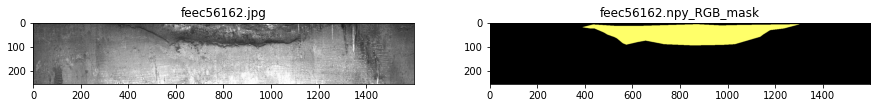

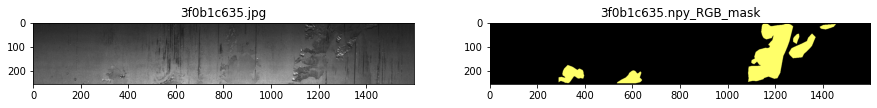

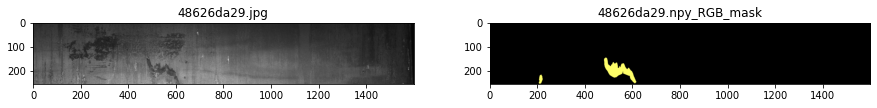

In [26]:
# Visualization: Sample images having defect
print('Images and masks with type3 defects')
cnt = 0
for i in X_train['ImageId'][(X_train.hasDefect_1 == 0) & (X_train.hasDefect_2 == 0) & (X_train.hasDefect_3 == 0) & (X_train.hasDefect_4 == 1)].values :
  if cnt < 3:
    fig, (ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize=(15, 10))
    img = cv2.imread(os.path.join(train_images_path , i))
    ax1.imshow(img)
    ax1.set_title(i)

    file_name = (i).split('.')[0] + '.npy'
    original_mask = np.load(os.path.join(train_masks_npy_path, file_name)) #256 X 1600X5
    original_mask = width_height_classes_toRGB(original_mask, classes_tocolour)
    # img = cv2.imread(os.path.join(train_images_path , i))
    ax2.imshow(original_mask)
    ax2.set_title(file_name + '_RGB_mask')
    # plt.show()
    cnt+=1
  else :
    break
print('-'*80)

Images and masks with defect 1, 2 and 3


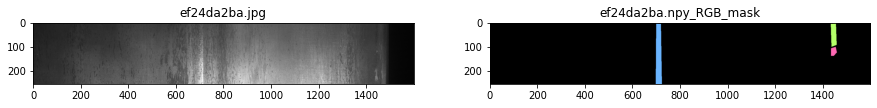

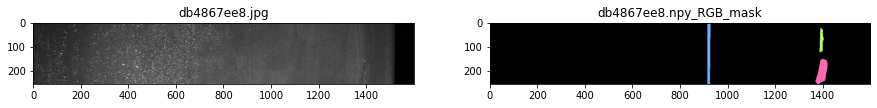

In [27]:
print('Images and masks with defect 1, 2 and 3')
cnt = 0
for i in X_train['ImageId'][(X_train.hasDefect_1 == 1) & (X_train.hasDefect_2 == 1) & (X_train.hasDefect_3 == 1) & (X_train.hasDefect_4 == 0)].values :
  if cnt < 3:
    fig, (ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize=(15, 10))
    img = cv2.imread(os.path.join(train_images_path , i))
    ax1.imshow(img)
    ax1.set_title(i)

    file_name = (i).split('.')[0] + '.npy'
    original_mask = np.load(os.path.join(train_masks_npy_path, file_name)) #256 X 1600X5
    original_mask = width_height_classes_toRGB(original_mask, classes_tocolour)
    # img = cv2.imread(os.path.join(train_images_path , i))
    ax2.imshow(original_mask)
    ax2.set_title(file_name + '_RGB_mask')
    plt.show()
    cnt+=1
  else :
    break

Images and masks with defect 3 and 4 


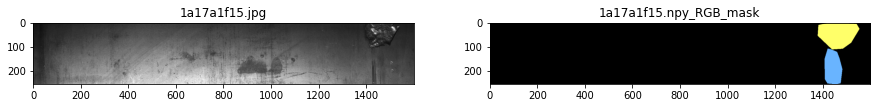

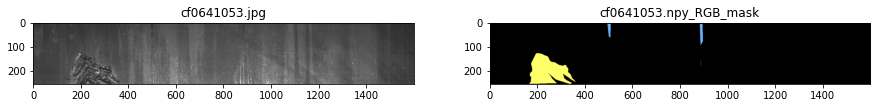

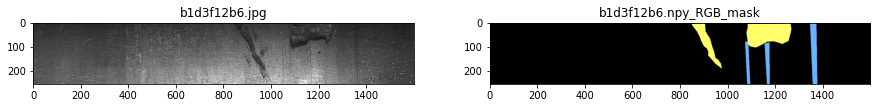

In [28]:
print('Images and masks with defect 3 and 4 ')
cnt = 0
for i in X_train['ImageId'][(X_train.hasDefect_1 == 0) & (X_train.hasDefect_2 == 0) & (X_train.hasDefect_3 == 1) & (X_train.hasDefect_4 == 1)].values :
  if cnt < 3:
    fig, (ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize=(15, 10))
    img = cv2.imread(os.path.join(train_images_path , i))
    ax1.imshow(img)
    ax1.set_title(i)

    file_name = (i).split('.')[0] + '.npy'
    original_mask = np.load(os.path.join(train_masks_npy_path, file_name)) #256 X 1600X5
    original_mask = width_height_classes_toRGB(original_mask, classes_tocolour)
    # img = cv2.imread(os.path.join(train_images_path , i))
    ax2.imshow(original_mask)
    ax2.set_title(file_name + '_RGB_mask')
    plt.show()
    cnt+=1
  else :
    break

In [31]:
# # Metrics
# # For image segmentation
# # COMPETITION METRIC
# # https://www.kaggle.com/xhlulu/severstal-simple-keras-u-net-boilerplate
#def dice_coef(y_true, y_pred, smooth=K.epsilon()):
#     '''
#     This function returns dice coefficient of similarity between y_true and y_pred
#     Dice coefficient is also referred to as F1_score, but we will use this name for image segmentation models
#     For example, 
#     let an instance on y_true and y_pred be [[1,1],[0,1]] and [[1,0],[0,1]]
#     this metric first converts the above into [1,1,0,1] abd [1,0,0,1],
#     then intersection is calculated as 1*1 + 1*0 + 0*1 + 1*1 = 2 and sum(y_true)+sum(y_pred)= 3+2 = 5
#     this returns the value (2.* 2 + 10e-7)/(3 + 2 + 10e-7) ~ 0.8    
#     '''
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# # Custom metrics, https://stackoverflow.com/questions/59196793/why-are-my-metrics-of-my-cnn-not-changing-with-each-epoch
# # For clasification
#def recall_m(y_true, y_pred):
#     '''
#     This function returns recall_score between y_true and y_pred
#     This function is ported as a metric to the Neural Network Models
#     Keras backend is used to take care of batch type training, the metric takes in a batch of y_pred and corresponding y_pred 
#     as input and returns recall score of the batch
#     '''
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # calculates number of true positives
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))      # calculates number of actual positives
#     recall = true_positives / (possible_positives + K.epsilon())   # K.epsilon takes care of non-zero divisions
#     return recall

#def precision_m(y_true, y_pred):
#     '''
#     This function returns precison_score between y_true and y_pred
#     This function is ported as a metric to the Neural Network Models
#     Keras backend is used to take care of batch type training, the metric takes in a batch of y_pred and corresponding y_pred 
#     as input and returns prediction score of the batch
#     '''
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # calculates number of true positives
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))      # calculates number of predicted positives   
#     precision = true_positives /(predicted_positives + K.epsilon()) # K.epsilon takes care of non-zero divisions
#     return precision
    

#def f1_score_m(y_true, y_pred):
#     '''
#     This function returns f1_score between y_true and y_pred
#     This 
#     This function is ported as a metric to the Neural Network Models
#     Keras backend is used to take care of batch type training, the metric takes in a batch of y_pred and corresponding y_pred 
#     as input and returns f1 score of the batch
#     '''
#     precision = precision_m(y_true, y_pred)  # calls precision metric and takes the score of precision of the batch
#     recall = recall_m(y_true, y_pred)        # calls recall metric and takes the score of precision of the batch
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))
#
#dependencies = {
#     'recall_m':recall_m,
#     'precision_m':precision_m,
#     'dice_coef':dice_coef,
#     'f1_score_m':f1_score_m,
#     'dice_loss':sm.losses.dice_loss
# }

Model Design Unet with Efficient net as encoder for multi label defect detection and use the encoder along with cusotm dense and dropout layers to detect the binary classification of detecting the 'hasdefect' and 'nodefect' images.

In [29]:
# updatable plot
# a minimal example (sort of)
from IPython.display import clear_output
from prettytable import PrettyTable
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.Iou_score =[]
        self.val_iou_score = []
        plt.figure(figsize=(35, 7))
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.Iou_score.append(logs.get('iou_score'))
        self.val_iou_score.append(logs.get('val_iou_score'))
        self.i += 1
        clear_output(wait=True)
        x = PrettyTable()
        x.add_column("Epoch",self.x)
        x.add_column("Loss",self.losses)
        x.add_column("Val_Loss",self.val_losses)
        x.add_column("Iou Scrore",self.Iou_score)
        x.add_column("Val_Iou Scrore",self.val_iou_score)
        print(x)
        plt.subplot(121)
        plt.plot(self.x, self.Iou_score, label="Iou_Score")
        plt.plot(self.x, self.val_iou_score, label="val_Iou_Score")
        plt.title('Model iou_score')
        plt.ylabel('iou_score')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')


        plt.subplot(122)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
plot_losses = PlotLosses()

In [30]:
class Plot_Binary_Losses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracy =[]
        self.val_accuracy = []
        plt.figure(figsize=(35, 7))
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))
        self.i += 1
        clear_output(wait=True)
        x = PrettyTable()
        x.add_column("Epoch",self.x)
        x.add_column("Loss",self.losses)
        x.add_column("Val_Loss",self.val_losses)
        x.add_column("accuracy",self.accuracy)
        x.add_column("Val_accuracy",self.val_accuracy)
        print(x)
        plt.subplot(121)
        plt.plot(self.x, self.accuracy, label="accuracy")
        plt.plot(self.x, self.val_accuracy, label="val_accuracy")
        plt.title('Model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')


        plt.subplot(122)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
plot_binary_losses = Plot_Binary_Losses()

In [31]:
def plot_confusion_matrix(test_y,predict_y,target_names):
    '''For the predicted and actual y, we will print the confusion matrix'''
    CM = multilabel_confusion_matrix(test_y, predict_y)  # 5 2X2
    # pdb.set_trace()
    for i in range(len(target_names)):
      C = CM[i,:,:]
      print("Confusion , Precision and recall matrices for {}".format(target_names[i]))
      R =(((C.T)/(C.sum(axis=1))).T)
      #divid each element of the confusion matrix with the sum of elements in that column

      P =(C/C.sum(axis=0))
      #divid each element of the confusion matrix with the sum of elements in that row

      plt.figure(figsize=(20,2))

      labels = [0,1]
      cmap=sns.light_palette("blue")
      plt.subplot(1, 3, 1)
      sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
      plt.xlabel('Predicted Class')
      plt.ylabel('Original Class')
      plt.title("Confusion matrix")

      plt.subplot(1, 3, 2)
      sns.heatmap(P, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
      plt.xlabel('Predicted Class')
      plt.ylabel('Original Class')
      plt.title("Precision matrix")

      plt.subplot(1, 3, 3)
      sns.heatmap(R, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
      plt.xlabel('Predicted Class')
      plt.ylabel('Original Class')
      plt.title("Recall matrix")
      plt.show()

In [32]:
X_train_binary = X_train[['ImageId','hasDefect']]
X_test_binary = X_train[['ImageId','hasDefect']]

Multilabel Classification model with efficient net B0 as back bone

In [33]:
class Unet_efficnetB0 :
  def __init__(self,input_shape,classes):
    tf.keras.backend.clear_session()
    self.input_shape = input_shape
    self.classes = classes
    self.inputs = Input(input_shape)
    self.encoder = EfficientNetB0(include_top=False, weights='imagenet', input_tensor= self.inputs)

  def conv_block(self,inputs,num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

  def decoder_block(self,inputs,skip, num_filters):
      x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
      x = Concatenate()([x, skip])
      x = self.conv_block(x, num_filters)
      return x

  def build_efficient_unet(self):
    
    s1 = self.encoder.get_layer("input_1").output  #skip connection 256X1600 

    s2 = self.encoder.get_layer("block2a_expand_activation").output  #skip connection 128X800

    s3 = self.encoder.get_layer("block3a_expand_activation").output  #skip connection 64X400

    s4 = self.encoder.get_layer("block4a_expand_activation").output  #skip connection 32X200

    """ Bottle neck"""

    b1 = self.encoder.get_layer("block6a_expand_activation").output  # 16X100

    """decoder block"""
    d1 = self.decoder_block(b1,s4,512) #32 X 200 X 512 

    d2 = self.decoder_block(d1,s3,256) #64 X 400 X 256

    d3 = self.decoder_block(d2,s2,128) #128 X 800 X 128
  
    d4 = self.decoder_block(d3,s1,64) #256 X 1600 X 128

    """Output"""
    outputs = Conv2D(self.classes,1,padding = "same" , activation= "softmax")(d4) 
    
    unet_model = Model(self.inputs , outputs, name = "EfficientNetB0_UNET") 

    return  unet_model
if __name__ == "__main__" :
  input_shape  = (256,1600,3)
  ueff = Unet_efficnetB0(input_shape = input_shape,classes = 5 )
  unet_model = ueff.build_efficient_unet()
  unet_model.summary()
  # model.get_layer("block6a_expand_activation") #16 X 100 X   

Model: "EfficientNetB0_UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 1600,   0           []                               
                                3)]                                                               
                                                                                                  
 rescaling (Rescaling)          (None, 256, 1600, 3  0           ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 normalization (Normalization)  (None, 256, 1600, 3  7           ['rescaling[0][0]']              
                                )                                               

                                                                                                  
 block2a_se_excite (Multiply)   (None, 64, 400, 96)  0           ['block2a_activation[0][0]',     
                                                                  'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, 64, 400, 24)  2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 64, 400, 24)  96         ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 64, 400, 144  3456        ['block2a_project_bn[0][0]']     
          

                                                                                                  
 block3a_project_bn (BatchNorma  (None, 32, 200, 40)  160        ['block3a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3b_expand_conv (Conv2D)   (None, 32, 200, 240  9600        ['block3a_project_bn[0][0]']     
                                )                                                                 
                                                                                                  
 block3b_expand_bn (BatchNormal  (None, 32, 200, 240  960        ['block3b_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block3b_e

                                )                                                                 
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, 16, 100, 480  1920       ['block4b_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block4b_expand_activation (Act  (None, 16, 100, 480  0          ['block4b_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block4b_dwconv (DepthwiseConv2  (None, 16, 100, 480  4320       ['block4b_expand_activation[0][0]
 D)                             )                                ']                               
          

 ization)                       )                                                                 
                                                                                                  
 block5a_expand_activation (Act  (None, 16, 100, 480  0          ['block5a_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block5a_dwconv (DepthwiseConv2  (None, 16, 100, 480  12000      ['block5a_expand_activation[0][0]
 D)                             )                                ']                               
                                                                                                  
 block5a_bn (BatchNormalization  (None, 16, 100, 480  1920       ['block5a_dwconv[0][0]']         
 )                              )                                                                 
          

 block5c_dwconv (DepthwiseConv2  (None, 16, 100, 672  16800      ['block5c_expand_activation[0][0]
 D)                             )                                ']                               
                                                                                                  
 block5c_bn (BatchNormalization  (None, 16, 100, 672  2688       ['block5c_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block5c_activation (Activation  (None, 16, 100, 672  0          ['block5c_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5c_se_squeeze (GlobalAver  (None, 672)         0           ['block5c_activation[0][0]']     
 agePoolin

 conv2d_3 (Conv2D)              (None, 64, 400, 256  590080      ['activation_2[0][0]']           
                                )                                                                 
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 64, 400, 256  1024       ['conv2d_3[0][0]']               
 rmalization)                   )                                                                 
                                                                                                  
 activation_3 (Activation)      (None, 64, 400, 256  0           ['batch_normalization_3[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 128, 800, 12  131200     ['activation_3[0][0]']           
 spose)   

In [34]:
# import imgaug.augmenters as iaa
# For the assignment choose any 4 augumentation techniques
# check the imgaug documentations for more augmentations
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))

In [35]:
ImageId= [ os.path.join(train_images_path,row.ImageId) for index,row in X_train.iterrows() ]
# MaskId= [ os.path.join(train_masks_path,row.ImageId) for index,row in X_train.iterrows() ]
X_train['ImageId'] = ImageId
# X_train['MaskId'] = MaskId

ImageId= [ os.path.join(train_images_path,row.ImageId) for index,row in X_test.iterrows() ]
# MaskId= [ os.path.join(train_masks_path,row.ImageId) for index,row in X_test.iterrows() ]
X_test['ImageId'] = ImageId
# X_test['MaskId'] = MaskId

In [36]:
class Dataset:
    def __init__(self, data_df, preparation_for):

        self.images_fps   = data_df['ImageId'].values
        self.mask_fps     = data_df['numpy_masks'].values
        #preparation for = train or test
        self.preparation_for = preparation_for
        self.w = 256
        self.h = 1600

    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image_mask = load(self.mask_fps[i])

        if self.preparation_for == 'train':
          a = np.random.uniform()
          if a<0.2:
              image = aug2.augment_image(image)
              image_mask = aug2.augment_image(image_mask)
          elif a<0.4:
              image = aug3.augment_image(image)
              image_mask = aug3.augment_image(image_mask)
          elif a<0.6:
              image = aug4.augment_image(image)
              image_mask = aug4.augment_image(image_mask)
          elif a<0.8:
              image = aug5.augment_image(image)
              image_mask = image_mask
        image = image.astype('float32')
        image_mask = image_mask.astype('float32')
        return image, image_mask

    def __len__(self):
        return len(self.images_fps)


class Dataloder(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):

        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return tuple(batch)

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [37]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lrate = LearningRateScheduler(scheduler)

es = tf.keras.callbacks.EarlyStopping( monitor='val_iou_score', patience= 10 , mode = 'max')

In [38]:
callbacks = [ tf.keras.callbacks.ModelCheckpoint('Severstaldataset-20230720T140741Z-001/Severstaldataset/best_multi_class_model.h5', save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_iou_score') ,
                                       plot_losses ,lrate,es ]

In [39]:
# import keras
# Dataset for train images
train_dataset = Dataset(X_train, 'train')
test_dataset  = Dataset(X_test, 'test')

BATCH_SIZE= 2
train_dataloader = Dataloder(train_dataset, batch_size= BATCH_SIZE, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size= BATCH_SIZE, shuffle=True)

print(train_dataloader[0][0].shape)
print(test_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)
print(test_dataloader[0][1].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 1600, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 1600, 5)

(2, 256, 1600, 3)
(2, 256, 1600, 3)
(2, 256, 1600, 5)
(2, 256, 1600, 5)


In [42]:
# https://github.com/qubvel/segmentation_models

# https://www.programmersought.com/article/34812621580/      to avoid common error of 'TFOptimizer' object has no attribute 'learning_rate'

optim = tf.keras.optimizers.Adam(learning_rate=0.001)
focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss
# or total_loss = sm.losses.categorical_focal_dice_loss
unet_model.compile(optim, focal_loss, metrics=[iou_score])

+-------+--------------------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |      Val_Loss      |      Iou Scrore     |    Val_Iou Scrore   |
+-------+--------------------+--------------------+---------------------+---------------------+
|   0   | 0.7827132344245911 | 0.7573755979537964 | 0.22865904867649078 | 0.24687950313091278 |
|   1   | 0.7630926370620728 | 0.7488142848014832 |  0.2427043467760086 |  0.2511497735977173 |
|   2   | 0.7517588138580322 | 0.7494494318962097 | 0.25001999735832214 |  0.2527563273906708 |
|   3   | 0.7447996735572815 | 0.7689681053161621 |  0.2553466558456421 | 0.23909085988998413 |
|   4   | 0.7385398745536804 | 0.7411284446716309 | 0.25972968339920044 |  0.2566100060939789 |
|   5   | 0.7343136072158813 | 0.7397088408470154 | 0.26280298829078674 |  0.2572607398033142 |
|   6   | 0.7283058762550354 | 0.7352734208106995 |  0.2671007513999939 |  0.2625489830970764 |
|   7   | 0.7246655225753784 | 0.7292029

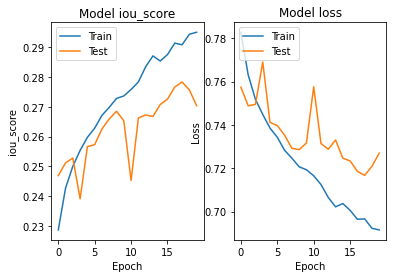

2513/2513 [==============================] - 961s 383ms/step - loss: 0.6916 - iou_score: 0.2950 - val_loss: 0.7270 - val_iou_score: 0.2703 - lr: 3.6788e-04


In [42]:
unet_history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//BATCH_SIZE ,epochs=20,\
                              validation_data = test_dataloader,callbacks=callbacks,\
                              validation_steps = len(test_dataloader)//BATCH_SIZE)

In [44]:
unet_model.load_weights('Severstaldataset-20230720T140741Z-001/Severstaldataset/best_multi_class_model.h5') 

In [45]:
# https://github.com/qubvel/segmentation_models

# https://www.programmersought.com/article/34812621580/      to avoid common error of 'TFOptimizer' object has no attribute 'learning_rate'

optim = tf.keras.optimizers.Adam(learning_rate=0.001)
focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss
# or total_loss = sm.losses.categorical_focal_dice_loss
unet_model.compile(optim, focal_loss, metrics=[iou_score])

+-------+--------------------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |      Val_Loss      |      Iou Scrore     |    Val_Iou Scrore   |
+-------+--------------------+--------------------+---------------------+---------------------+
|   0   | 0.7066071629524231 | 0.7171043753623962 |  0.2836487293243408 |  0.2761850953102112 |
|   1   | 0.7010670900344849 | 0.7185555100440979 |  0.2873188853263855 |  0.2734200060367584 |
|   2   | 0.703178346157074  | 0.7922509908676147 | 0.28625550866127014 | 0.23052185773849487 |
|   3   | 0.7036246061325073 | 0.7212148904800415 |  0.2861033082008362 |  0.2744075059890747 |
|   4   |  0.70477694272995  | 0.744473397731781  | 0.28456249833106995 | 0.26099395751953125 |
|   5   | 0.7013503909111023 | 0.725426971912384  | 0.28738564252853394 | 0.26934969425201416 |
|   6   | 0.7007302641868591 | 0.7340558767318726 | 0.28792837262153625 | 0.26554158329963684 |
|   7   | 0.6999751925468445 | 0.7133982

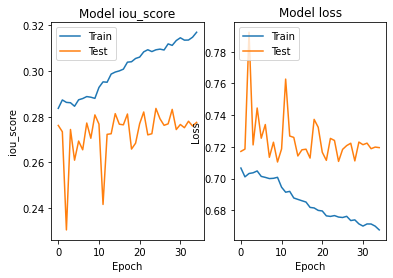

2513/2513 [==============================] - 961s 382ms/step - loss: 0.6676 - iou_score: 0.3169 - val_loss: 0.7195 - val_iou_score: 0.2775 - lr: 8.2085e-05


In [46]:
unet_history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//BATCH_SIZE ,epochs=500,\
                              validation_data = test_dataloader,callbacks=callbacks,\
                              validation_steps = len(test_dataloader)//BATCH_SIZE)

Comparing the masks predicted by the model and the original masks.

In [40]:
unet_model.load_weights('Severstaldataset-20230720T140741Z-001/Severstaldataset/best_multi_class_model.h5') 

Images and masks with out any defects
1/1 [==============================] - 22s 22s/step


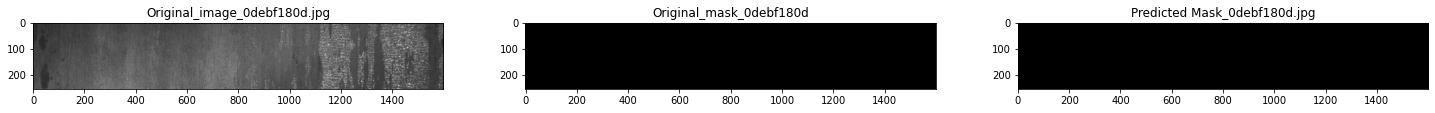

1/1 [==============================] - 0s 40ms/step


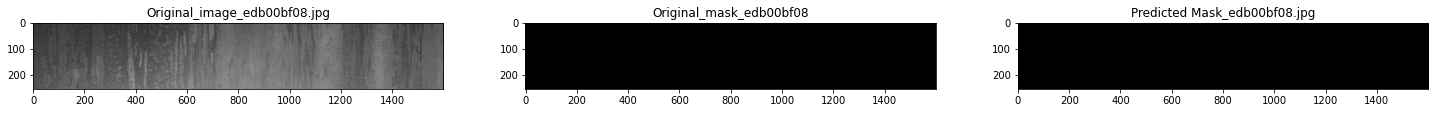

1/1 [==============================] - 0s 70ms/step


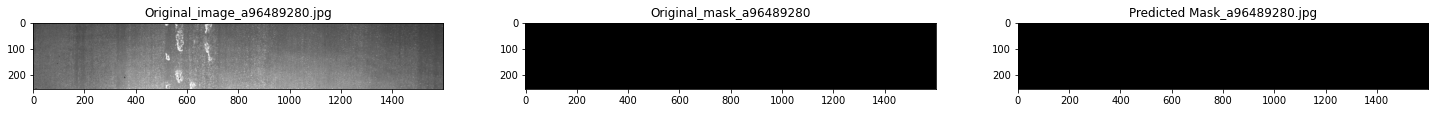

--------------------------------------------------------------------------------


In [41]:
# # Visualization: Sample original and predicted masks
print('Images and masks with out any defects')
cnt = 0
for i in X_test['ImageId'][X_test.hasDefect == 0 ].values :
  if cnt < 3:
    fig, (ax1,ax2,ax3) = plt.subplots(nrows = 1,ncols = 3,figsize=(25, 6))
    img = cv2.imread(i)
    # pdb.set_trace()
    ax1.imshow(img)
    ax1.set_title('Original_image_'+os.path.split(i)[1])
    file_name = os.path.split(i)[1].split('.')[0] + '.npy'
    original_mask = np.load(os.path.join(train_masks_npy_path, file_name)) #256 X 1600X3
    original_mask = width_height_classes_toRGB(original_mask, classes_tocolour)
    ax2.imshow(original_mask)
    ax2.set_title('Original_mask_'+os.path.split(file_name)[1].split('.')[0]) 
    
    img = cv2.imread( i)
    predict_mask = unet_model.predict(np.expand_dims(img, axis=0)).argmax(axis = -1) #256X1600X5 
    # pdb.set_trace() 
    predict_mask  = np.squeeze(predict_mask, axis=0)
    predict_mask  = one_frame_rgb(predict_mask,classes_tocolour)
    
    # predict_mask = width_height_classes_toRGB(predict_mask, classes_tocolour)
    ax3.imshow(predict_mask)
    ax3.set_title('Predicted Mask_'+os.path.split(i)[1])
    plt.show()
    cnt+=1 
  else :
    break
print('-'*80)   

Observation: the image has no defect and hence the predicted image is completely black

Images and masks with type1 defects
1/1 [==============================] - 0s 30ms/step


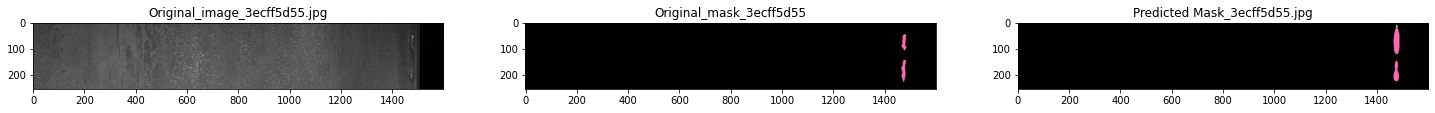

1/1 [==============================] - 0s 26ms/step


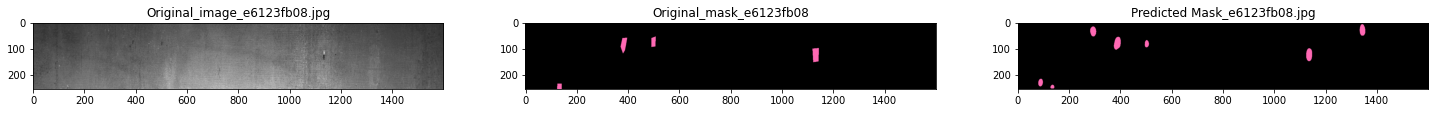

1/1 [==============================] - 0s 23ms/step


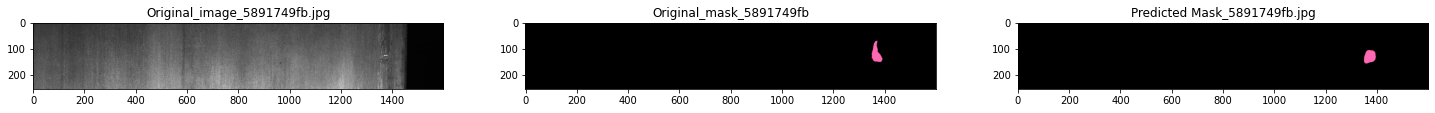

--------------------------------------------------------------------------------


In [47]:
# # Visualization: Sample original and predicted masks
print('Images and masks with type1 defects')
cnt = 0
for i in X_test['ImageId'][(X_test.hasDefect_1 == 1) & (X_test.hasDefect_2 == 0) & (X_test.hasDefect_3 == 0) & (X_test.hasDefect_4 == 0)].values :
  if cnt < 3:
    fig, (ax1,ax2,ax3) = plt.subplots(nrows = 1,ncols = 3,figsize=(25, 6))
    img = cv2.imread(i)
    # pdb.set_trace()
    ax1.imshow(img)
    ax1.set_title('Original_image_'+os.path.split(i)[1])
    file_name = os.path.split(i)[1].split('.')[0] + '.npy'
    original_mask = np.load(os.path.join(train_masks_npy_path, file_name)) #256 X 1600X3
    original_mask = width_height_classes_toRGB(original_mask, classes_tocolour)
    ax2.imshow(original_mask)
    ax2.set_title('Original_mask_'+os.path.split(file_name)[1].split('.')[0]) 
    
    img = cv2.imread( i)
    predict_mask = unet_model.predict(np.expand_dims(img, axis=0)).argmax(axis = -1) #256X1600X5 
    # pdb.set_trace() 
    predict_mask  = np.squeeze(predict_mask, axis=0)
    predict_mask  = one_frame_rgb(predict_mask,classes_tocolour)
    
    # predict_mask = width_height_classes_toRGB(predict_mask, classes_tocolour)
    ax3.imshow(predict_mask)
    ax3.set_title('Predicted Mask_'+os.path.split(i)[1])
    plt.show()
    cnt+=1 
  else :
    break
print('-'*80)   

Observation: We can observe that the model can able to predict most of the defect 1 spots.

Images and masks with type2 defects
1/1 [==============================] - 0s 23ms/step


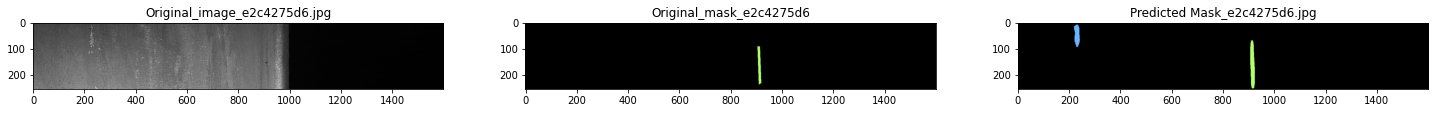

1/1 [==============================] - 0s 23ms/step


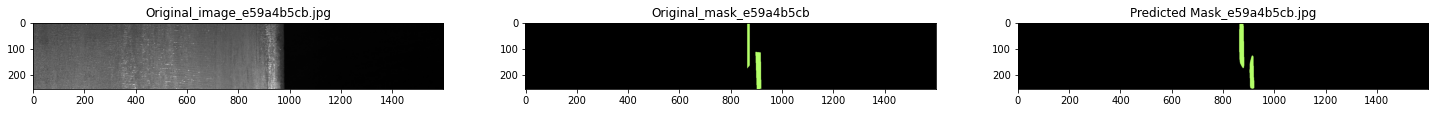

1/1 [==============================] - 0s 25ms/step


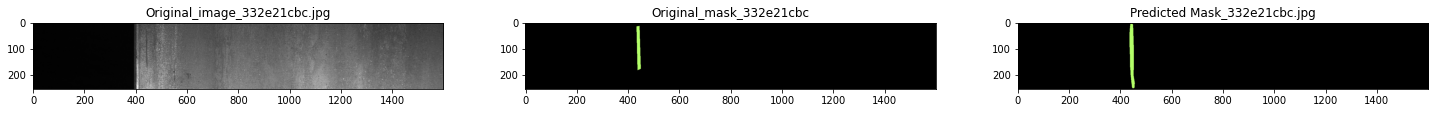

--------------------------------------------------------------------------------


In [49]:
# # Visualization: Sample original and predicted masks
print('Images and masks with type2 defects')
cnt = 0
for i in X_test['ImageId'][(X_test.hasDefect_1 == 0) & (X_test.hasDefect_2 == 1) & (X_test.hasDefect_3 == 0) & (X_test.hasDefect_4 == 0)].values :
  if cnt < 3:
    fig, (ax1,ax2,ax3) = plt.subplots(nrows = 1,ncols = 3,figsize=(25, 6))
    img = cv2.imread(i)
    # pdb.set_trace()
    ax1.imshow(img)
    ax1.set_title('Original_image_'+os.path.split(i)[1])
    file_name = os.path.split(i)[1].split('.')[0] + '.npy'
    original_mask = np.load(os.path.join(train_masks_npy_path, file_name)) #256 X 1600X3
    original_mask = width_height_classes_toRGB(original_mask, classes_tocolour)
    ax2.imshow(original_mask)
    ax2.set_title('Original_mask_'+os.path.split(file_name)[1].split('.')[0]) 
    
    img = cv2.imread( i)
    predict_mask = unet_model.predict(np.expand_dims(img, axis=0)).argmax(axis = -1) #256X1600X5 
    # pdb.set_trace() 
    predict_mask  = np.squeeze(predict_mask, axis=0)
    predict_mask  = one_frame_rgb(predict_mask,classes_tocolour)
    
    # predict_mask = width_height_classes_toRGB(predict_mask, classes_tocolour)
    ax3.imshow(predict_mask)
    ax3.set_title('Predicted Mask_'+os.path.split(i)[1])
    plt.show()
    cnt+=1 
  else :
    break
print('-'*80) 

Observation: Model is very much poor in detecting the type 2 defects. One reason can be data related to type 2 defects is very less.

Images and masks with type3 defects
1/1 [==============================] - 0s 29ms/step


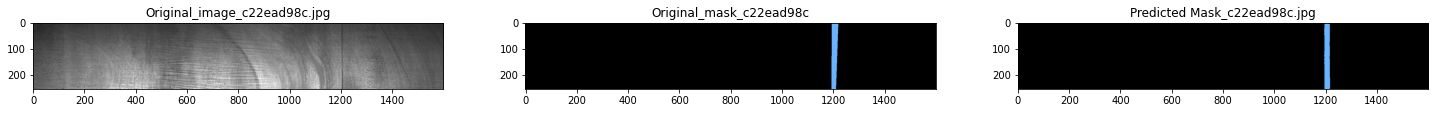

1/1 [==============================] - 0s 27ms/step


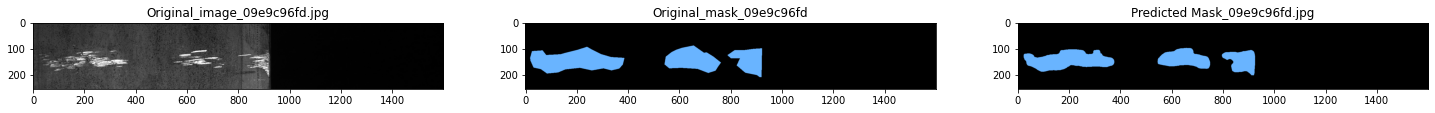

1/1 [==============================] - 0s 23ms/step


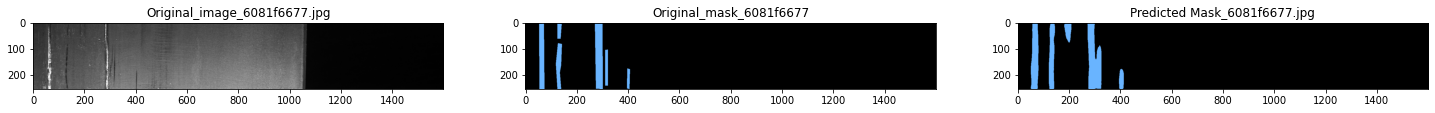

--------------------------------------------------------------------------------


In [51]:
# # Visualization: Sample original and predicted masks
print('Images and masks with type3 defects')
cnt = 0
for i in X_test['ImageId'][(X_test.hasDefect_1 == 0) & (X_test.hasDefect_2 == 0) & (X_test.hasDefect_3 == 1) & (X_test.hasDefect_4 == 0)].values :
  if cnt < 3:
    fig, (ax1,ax2,ax3) = plt.subplots(nrows = 1,ncols = 3,figsize=(25, 6))
    img = cv2.imread(i)
    # pdb.set_trace()
    ax1.imshow(img)
    ax1.set_title('Original_image_'+os.path.split(i)[1])
    file_name = os.path.split(i)[1].split('.')[0] + '.npy'
    original_mask = np.load(os.path.join(train_masks_npy_path, file_name)) #256 X 1600X3
    original_mask = width_height_classes_toRGB(original_mask, classes_tocolour)
    ax2.imshow(original_mask)
    ax2.set_title('Original_mask_'+os.path.split(file_name)[1].split('.')[0]) 
    
    img = cv2.imread( i)
    predict_mask = unet_model.predict(np.expand_dims(img, axis=0)).argmax(axis = -1) #256X1600X1 
    # pdb.set_trace() 
    predict_mask  = np.squeeze(predict_mask, axis=0)
    predict_mask  = one_frame_rgb(predict_mask,classes_tocolour)
    
    # predict_mask = width_height_classes_toRGB(predict_mask, classes_tocolour)
    ax3.imshow(predict_mask)
    ax3.set_title('Predicted Mask_'+os.path.split(i)[1])
    plt.show()
    cnt+=1 
  else :
    break
print('-'*80)  

Observation: model is very much capable of detecting the 3rd type defect aswell.

Images and masks with type4 defects
1/1 [==============================] - 0s 24ms/step


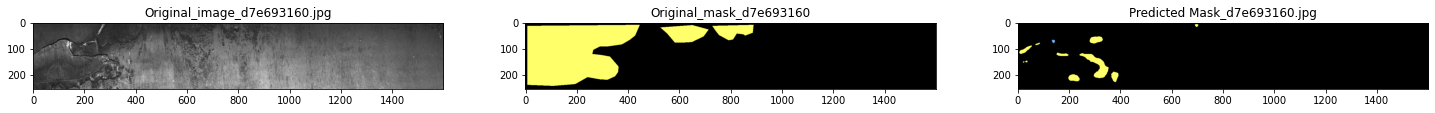

1/1 [==============================] - 0s 23ms/step


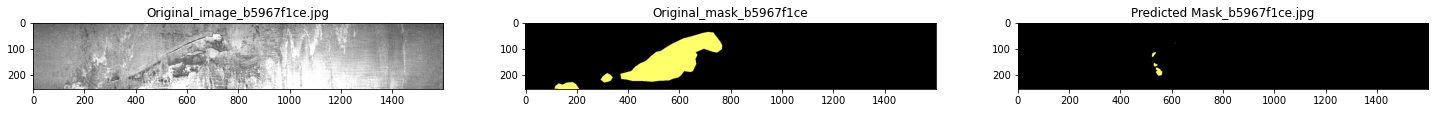

1/1 [==============================] - 0s 25ms/step


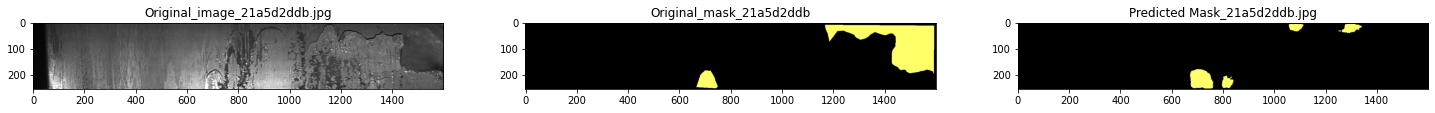

--------------------------------------------------------------------------------


In [52]:
# # Visualization: Sample original and predicted masks
print('Images and masks with type4 defects')
cnt = 0
for i in X_test['ImageId'][(X_test.hasDefect_1 == 0) & (X_test.hasDefect_2 == 0) & (X_test.hasDefect_3 == 0) & (X_test.hasDefect_4 == 1)].values :
  if cnt < 3:
    fig, (ax1,ax2,ax3) = plt.subplots(nrows = 1,ncols = 3,figsize=(25, 6))
    img = cv2.imread(i)
    # pdb.set_trace()
    ax1.imshow(img)
    ax1.set_title('Original_image_'+os.path.split(i)[1])
    file_name = os.path.split(i)[1].split('.')[0] + '.npy'
    original_mask = np.load(os.path.join(train_masks_npy_path, file_name)) #256 X 1600X3
    original_mask = width_height_classes_toRGB(original_mask, classes_tocolour)
    ax2.imshow(original_mask)
    ax2.set_title('Original_mask_'+os.path.split(file_name)[1].split('.')[0]) 
    
    img = cv2.imread( i)
    predict_mask = unet_model.predict(np.expand_dims(img, axis=0)).argmax(axis = -1) #256X1600X5 
    # pdb.set_trace() 
    predict_mask  = np.squeeze(predict_mask, axis=0)
    predict_mask  = one_frame_rgb(predict_mask,classes_tocolour)
    
    # predict_mask = width_height_classes_toRGB(predict_mask, classes_tocolour)
    ax3.imshow(predict_mask)
    ax3.set_title('Predicted Mask_'+os.path.split(i)[1])
    plt.show()
    cnt+=1 
  else :
    break
print('-'*80)   

In [42]:
def final_fun_1(X) :
    ''' Takes  ImageID  and do image segmentation for different type of defects'''
    ImageId= os.path.join(train_images_path,X) 
    img = cv2.imread(ImageId)
    predict_mask = unet_model.predict(np.expand_dims(img, axis=0)).argmax(axis = -1) #256X1600X1
    return predict_mask
     

Observation: Above plots show that, the model prediction order is as below defect3 > defect 1 > defect4 > defect2

and this order order is same as the distribution of defects in the given data.

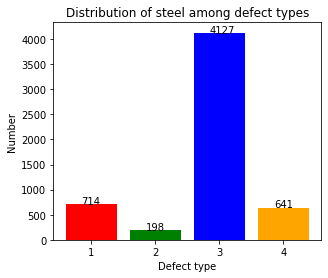

In [54]:
plt.figure(figsize = (4.8, 4))
plt.xlabel('Defect type')
plt.ylabel('Number')
plt.bar([1,2,3,4],X_train[['hasDefect_1','hasDefect_2','hasDefect_3','hasDefect_4']].sum(axis = 0),
        color = ['red','green','blue','orange'] , width = 0.8)
xlocs, xlabs = plt.xticks()
plt.title('Distribution of steel among defect types')
for i, v in zip([1,2,3,4],X_train[['hasDefect_1','hasDefect_2','hasDefect_3','hasDefect_4']].sum(axis = 0)):
    plt.text(xlocs[i] - 0.15, v + 0.5, str(v))
plt.show()

confusion matrix for the predictions made by multilabel classefier on test data.

In [47]:
X_test_actual  = X_test[['hasDefect','hasDefect_1','hasDefect_2','hasDefect_3','hasDefect_4']].to_numpy()
X_test_predict = []
for i in X_test['ImageId'].values:
  X_test_predict_i = []
  img = cv2.imread(i)
  predict_mask = unet_model.predict(np.expand_dims(img, axis=0)).argmax(axis = -1) #256X1600X5 
  predict_mask  = np.squeeze(predict_mask, axis=0)
  hasDefect = 0 
  hasDefect_1 = 0
  hasDefect_2 = 0
  hasDefect_3 = 0 
  hasDefect_4 = 0 
  if ( predict_mask == 1 ).sum()  :
    hasDefect = 1 
    hasDefect_1 = 1

  if ( predict_mask == 2 ).sum()  :
    hasDefect = 1 
    hasDefect_2 = 1

  if ( predict_mask == 3 ).sum() :
    hasDefect = 1 
    hasDefect_3 = 1

  if ( predict_mask == 4 ).sum() :
    hasDefect = 1 
    hasDefect_4 = 1
  X_test_predict_i = [hasDefect,hasDefect_1,hasDefect_2,hasDefect_3,hasDefect_4]
  X_test_predict.append(X_test_predict_i)

X_test_predict = np.array(X_test_predict)

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 67ms/step


In [48]:
target_names = ['hasDefect','hasDefect_1','hasDefect_2','hasDefect_3','hasDefect_4']

Confusion , Precision and recall matrices for hasDefect


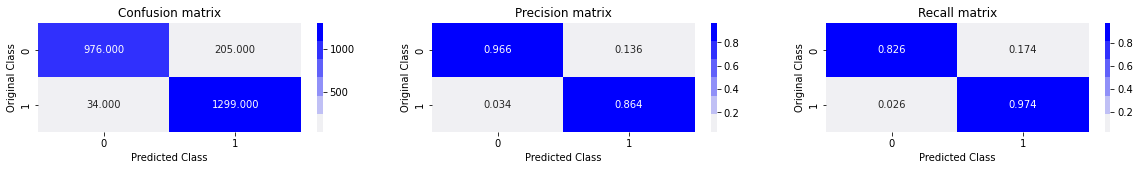

Confusion , Precision and recall matrices for hasDefect_1


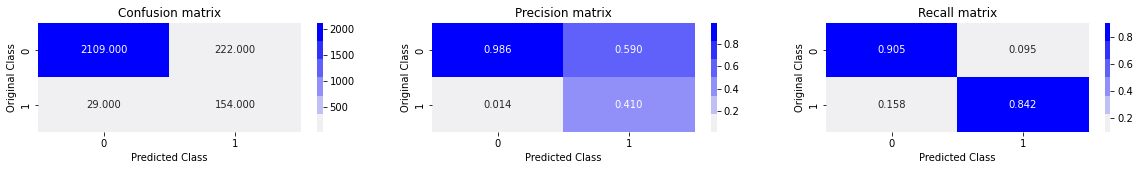

Confusion , Precision and recall matrices for hasDefect_2


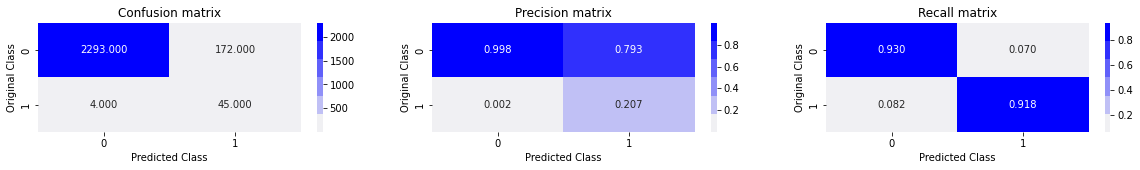

Confusion , Precision and recall matrices for hasDefect_3


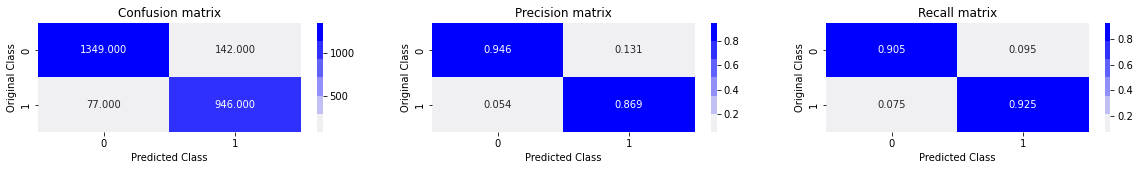

Confusion , Precision and recall matrices for hasDefect_4


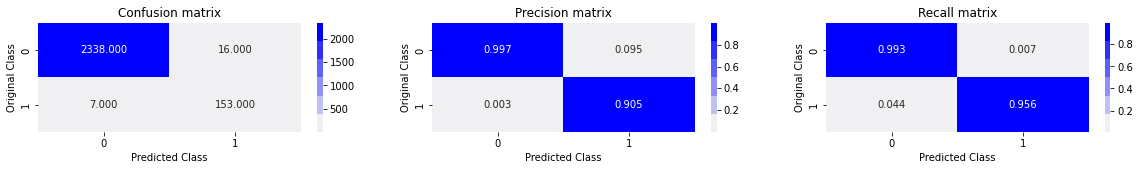

In [49]:
plot_confusion_matrix(X_test_actual,X_test_predict,target_names)

In [39]:
# https://github.com/qubvel/segmentation_models

# https://www.programmersought.com/article/34812621580/      to avoid common error of 'TFOptimizer' object has no attribute 'learning_rate'

optim = tf.keras.optimizers.Adam(learning_rate=0.001)
focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss
# or total_loss = sm.losses.categorical_focal_dice_loss
unet_model.compile(optim, focal_loss, metrics=[iou_score])

In [44]:
unet_history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//BATCH_SIZE ,epochs=500,\
                              validation_data = test_dataloader,callbacks=callbacks,\
                              validation_steps = len(test_dataloader)//BATCH_SIZE)

<ipython-input-44-94d5591a32ae>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  unet_history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//BATCH_SIZE ,epochs=500,\


Epoch 1/500


InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_187' defined at (most recent call last):
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 619, in start
      self.io_loop.start()
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 358, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 536, in execute_request
      self.do_execute(
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-40-94d5591a32ae>", line 1, in <module>
      unet_history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//BATCH_SIZE ,epochs=500,\
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/keras/engine/training.py", line 2636, in fit_generator
      return self.fit(
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/keras/engine/training.py", line 1054, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 543, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 1174, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 650, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 1200, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 1250, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/maraden/miniconda3/envs/TA/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 1245, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_187'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_187}}]] [Op:__inference_train_function_25206]

<Figure size 2520x504 with 0 Axes>

In [42]:
unet_model.load_weights('Severstaldataset-20230720T140741Z-001/Severstaldataset/best_multi_class_model.h5') 

optim SGD, lr = 0.001, epoch = 40

In [43]:
# https://github.com/qubvel/segmentation_models

# https://www.programmersought.com/article/34812621580/      to avoid common error of 'TFOptimizer' object has no attribute 'learning_rate'

optim = tf.keras.optimizers.SGD(learning_rate=0.001)
focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss  
unet_model.compile(optim, focal_loss, metrics=[iou_score])

+-------+--------------------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |      Val_Loss      |      Iou Scrore     |    Val_Iou Scrore   |
+-------+--------------------+--------------------+---------------------+---------------------+
|   0   | 0.6724568605422974 | 0.712571382522583  |  0.3127098083496094 | 0.28152403235435486 |
|   1   | 0.6730728149414062 | 0.7191475629806519 | 0.31215232610702515 |  0.2780221104621887 |
|   2   | 0.6736059188842773 | 0.7115155458450317 |  0.3116360008716583 | 0.28305259346961975 |
|   3   | 0.6750362515449524 | 0.7141869068145752 |  0.310513973236084  | 0.28064313530921936 |
|   4   | 0.6731142401695251 | 0.7125244736671448 | 0.31201741099357605 | 0.28206270933151245 |
|   5   | 0.6722806096076965 | 0.7114186882972717 | 0.31256911158561707 |  0.2829078733921051 |
+-------+--------------------+--------------------+---------------------+---------------------+


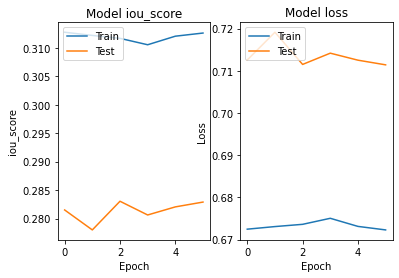

2513/2513 [==============================] - 1085s 432ms/step - loss: 0.6723 - iou_score: 0.3126 - val_loss: 0.7114 - val_iou_score: 0.2829 - lr: 0.0010
Epoch 7/40
 616/2513 [======>.......................] - ETA: 13:47 - loss: 0.6686 - iou_score: 0.3153

In [ ]:
unet_history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//BATCH_SIZE ,epochs=40,\
                              validation_data = test_dataloader,callbacks=callbacks,\
                              validation_steps = len(test_dataloader)//BATCH_SIZE)

optim SGD, lr = 0.001, epoch = 40

In [43]:
unet_model.load_weights('Severstaldataset-20230720T140741Z-001/Severstaldataset/best_multi_class_model.h5') 

In [44]:
# https://github.com/qubvel/segmentation_models

# https://www.programmersought.com/article/34812621580/      to avoid common error of 'TFOptimizer' object has no attribute 'learning_rate'

optim = tf.keras.optimizers.SGD(learning_rate=0.001)
focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss  
unet_model.compile(optim, focal_loss, metrics=[iou_score])

+-------+--------------------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |      Val_Loss      |      Iou Scrore     |    Val_Iou Scrore   |
+-------+--------------------+--------------------+---------------------+---------------------+
|   0   | 0.6722422242164612 | 0.7162684798240662 | 0.31267422437667847 |  0.2798561453819275 |
|   1   | 0.6741665601730347 | 0.7132730484008789 | 0.31085002422332764 | 0.28159722685813904 |
|   2   | 0.6693641543388367 | 0.7101057767868042 | 0.31505632400512695 |  0.2830961346626282 |
|   3   | 0.6722502708435059 | 0.7148988842964172 | 0.31268149614334106 |  0.2808722257614136 |
|   4   | 0.6726800203323364 | 0.7105302810668945 |  0.3122867941856384 |  0.2835121154785156 |
|   5   | 0.6733777523040771 | 0.717724621295929  |  0.311567097902298  | 0.27891820669174194 |
|   6   | 0.6712589859962463 | 0.7117661237716675 |   0.31336510181427  | 0.28245484828948975 |
|   7   | 0.6741263270378113 | 0.7087820

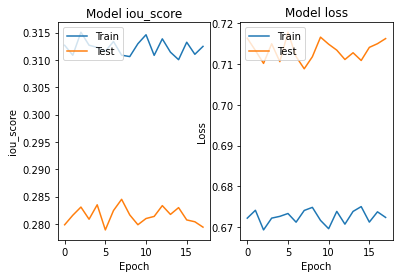

2513/2513 [==============================] - 880s 350ms/step - loss: 0.6724 - iou_score: 0.3125 - val_loss: 0.7162 - val_iou_score: 0.2794 - lr: 4.4933e-04


In [45]:
unet_history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//BATCH_SIZE ,epochs=40,\
                              validation_data = test_dataloader,callbacks=callbacks,\
                              validation_steps = len(test_dataloader)//BATCH_SIZE)

optim RMSprop, lr = 0.001, epoch = 40

In [50]:
# https://github.com/qubvel/segmentation_models

# https://www.programmersought.com/article/34812621580/      to avoid common error of 'TFOptimizer' object has no attribute 'learning_rate'

optim = tf.keras.optimizers.RMSprop(learning_rate=0.001)
focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss  
unet_model.compile(optim, focal_loss, metrics=[iou_score])

+-------+--------------------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |      Val_Loss      |      Iou Scrore     |    Val_Iou Scrore   |
+-------+--------------------+--------------------+---------------------+---------------------+
|   0   | 0.6772190928459167 | 0.7361462116241455 |  0.3082124888896942 | 0.26785463094711304 |
|   1   | 0.6782033443450928 | 0.7210530638694763 | 0.30740052461624146 | 0.27698394656181335 |
|   2   | 0.677644670009613  | 0.7457073330879211 |  0.3081124424934387 |  0.2598581910133362 |
|   3   | 0.6786614656448364 | 0.7176983952522278 |  0.3067415654659271 | 0.27739521861076355 |
|   4   | 0.6770569086074829 | 0.7434378266334534 | 0.30802783370018005 |  0.2631850242614746 |
|   5   | 0.6783481240272522 | 0.7322527170181274 |  0.307708740234375  | 0.26907649636268616 |
|   6   | 0.6742674708366394 | 0.7155871391296387 | 0.31106147170066833 | 0.28042325377464294 |
|   7   | 0.6758524179458618 | 0.7233349

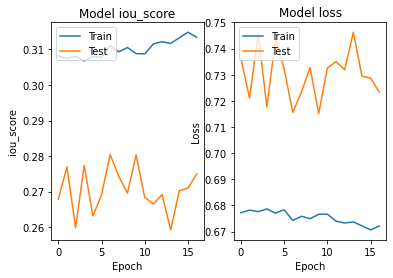

2513/2513 [==============================] - 888s 353ms/step - loss: 0.6721 - iou_score: 0.3134 - val_loss: 0.7233 - val_iou_score: 0.2750 - lr: 4.9659e-04


In [51]:
unet_history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//BATCH_SIZE ,epochs=40,\
                              validation_data = test_dataloader,callbacks=callbacks,\
                              validation_steps = len(test_dataloader)//BATCH_SIZE)

optim RMSprop, lr = 0.001, epoch = 40

In [42]:
unet_model.load_weights('Severstaldataset-20230720T140741Z-001/Severstaldataset/best_multi_class_model.h5') 

In [43]:
# https://github.com/qubvel/segmentation_models

# https://www.programmersought.com/article/34812621580/      to avoid common error of 'TFOptimizer' object has no attribute 'learning_rate'

optim = tf.keras.optimizers.RMSprop(learning_rate=0.001)
focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss  
unet_model.compile(optim, focal_loss, metrics=[iou_score])

+-------+--------------------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |      Val_Loss      |      Iou Scrore     |    Val_Iou Scrore   |
+-------+--------------------+--------------------+---------------------+---------------------+
|   0   | 0.7593230605125427 | 0.7469360828399658 | 0.24579790234565735 | 0.25383687019348145 |
|   1   | 0.7499595284461975 | 0.7560227513313293 |  0.2516259551048279 | 0.25127002596855164 |
|   2   | 0.7455201148986816 | 0.737865686416626  | 0.25433364510536194 |  0.2595990002155304 |
|   3   | 0.7383911609649658 | 0.7638891339302063 | 0.26035764813423157 | 0.24085403978824615 |
|   4   | 0.7344973087310791 | 0.7451841831207275 |  0.2629100978374481 | 0.25414782762527466 |
|   5   | 0.7295674085617065 | 0.7374514937400818 |  0.2670573592185974 | 0.25938284397125244 |
|   6   | 0.7251591086387634 | 0.7372379302978516 |  0.2699660360813141 |  0.2639254927635193 |
|   7   | 0.7206816077232361 | 0.7372406

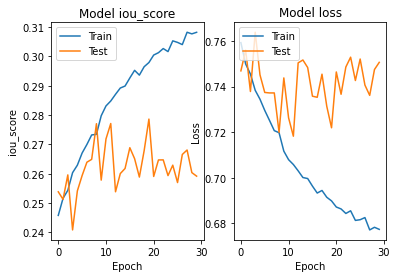

2513/2513 [==============================] - 953s 379ms/step - loss: 0.6773 - iou_score: 0.3082 - val_loss: 0.7507 - val_iou_score: 0.2592 - lr: 1.3534e-04


In [44]:
unet_history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//BATCH_SIZE ,epochs=40,\
                              validation_data = test_dataloader,callbacks=callbacks,\
                              validation_steps = len(test_dataloader)//BATCH_SIZE)

optim RMSprop, lr = 0.01, epoch = 40

In [45]:
unet_model.load_weights('Severstaldataset-20230720T140741Z-001/Severstaldataset/best_multi_class_model.h5') 

In [51]:
# https://github.com/qubvel/segmentation_models

# https://www.programmersought.com/article/34812621580/      to avoid common error of 'TFOptimizer' object has no attribute 'learning_rate'

optim = tf.keras.optimizers.RMSprop(learning_rate=0.01)
focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss  
unet_model.compile(optim, focal_loss, metrics=[iou_score])

+-------+--------------------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |      Val_Loss      |      Iou Scrore     |    Val_Iou Scrore   |
+-------+--------------------+--------------------+---------------------+---------------------+
|   0   | 0.7857309579849243 | 0.7690441608428955 | 0.22663123905658722 | 0.23997987806797028 |
|   1   | 0.7695460319519043 | 0.7602435946464539 | 0.23751558363437653 |  0.2406695932149887 |
|   2   | 0.7597683668136597 | 0.7745410799980164 |  0.2445942759513855 | 0.23950102925300598 |
|   3   | 0.7562898397445679 | 0.7673603892326355 |  0.2469417154788971 |  0.2419259399175644 |
|   4   | 0.7534254789352417 | 0.7608929872512817 |  0.2493489384651184 |  0.2450762689113617 |
|   5   | 0.7512277960777283 | 0.7684370279312134 | 0.25117719173431396 |  0.2430163025856018 |
|   6   | 0.7512094378471375 | 0.769232988357544  | 0.25050702691078186 |  0.2403060495853424 |
|   7   | 0.7471081614494324 | 0.7674403

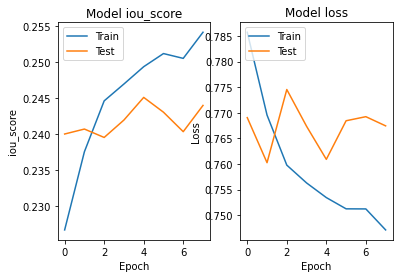

2513/2513 [==============================] - 955s 380ms/step - loss: 0.7471 - iou_score: 0.2541 - val_loss: 0.7674 - val_iou_score: 0.2440 - lr: 0.0100
Epoch 9/40
1469/2513 [================>.............] - ETA: 6:10 - loss: 0.7429 - iou_score: 0.2575

In [ ]:
unet_history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//BATCH_SIZE ,epochs=40,\
                              validation_data = test_dataloader,callbacks=callbacks,\
                              validation_steps = len(test_dataloader)//BATCH_SIZE)

In [45]:
unet_model.load_weights('Severstaldataset-20230720T140741Z-001/Severstaldataset/best_multi_class_model.h5') 

In [46]:
# https://github.com/qubvel/segmentation_models

# https://www.programmersought.com/article/34812621580/      to avoid common error of 'TFOptimizer' object has no attribute 'learning_rate'

optim = tf.keras.optimizers.Adam(learning_rate=0.01)
focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss
# or total_loss = sm.losses.categorical_focal_dice_loss
unet_model.compile(optim, focal_loss, metrics=[iou_score])

+-------+--------------------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |      Val_Loss      |      Iou Scrore     |    Val_Iou Scrore   |
+-------+--------------------+--------------------+---------------------+---------------------+
|   0   | 0.7983751893043518 | 0.7896429896354675 | 0.21707890927791595 |  0.2223970741033554 |
|   1   | 0.7884673476219177 | 0.7881026268005371 |  0.2230176478624344 | 0.22951623797416687 |
|   2   | 0.777484655380249  | 0.7819941639900208 | 0.23091882467269897 | 0.22274133563041687 |
|   3   | 0.7685705423355103 | 0.7743089199066162 |  0.2370699644088745 |  0.2350594401359558 |
|   4   | 0.7647369503974915 | 0.7788733839988708 | 0.24004116654396057 | 0.23365209996700287 |
|   5   | 0.7630570530891418 | 0.7643002271652222 | 0.24055729806423187 | 0.24281510710716248 |
|   6   | 0.7598145604133606 | 0.7851890921592712 |  0.2434743195772171 | 0.22874069213867188 |
|   7   | 0.7593386173248291 | 0.7695373

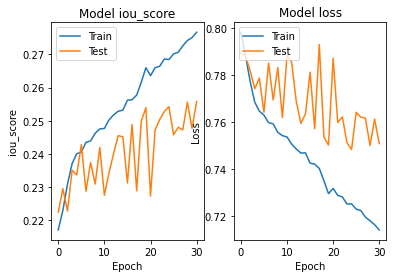

2513/2513 [==============================] - 962s 383ms/step - loss: 0.7141 - iou_score: 0.2767 - val_loss: 0.7509 - val_iou_score: 0.2558 - lr: 0.0012
Epoch 32/40
1225/2513 [=============>................] - ETA: 7:40 - loss: 0.7102 - iou_score: 0.2795

In [ ]:
unet_history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//BATCH_SIZE ,epochs=40,\
                              validation_data = test_dataloader,callbacks=callbacks,\
                              validation_steps = len(test_dataloader)//BATCH_SIZE)